In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
from scipy.optimize import minimize

# Load test samples
from aeons.tools import pickle_in
samples_g_1, samples_c_1, samples_w_1 = pickle_in("../test_samples/samples_1.pickle")

from aeons.covariance import logX_mu, logX_covinv_chol, points_at_iteration, X_mu, X_Sigmainv, data_at_iteration
from aeons.true_distribution import generate_Xs

#### **Derive marginalised probability**
Ultimately want to maximise $P(\theta | \log \bm{L})$. Bayes' rule to invert in terms of known quantities 

$$P(\theta | \log \bm{L}) = \int P(\bm{X}, \theta | \log \bm{L})\ d\bm{X} = \int \frac{P(\bm{X}, \theta, \log \bm{L})}{P(\log \bm{L})}$$

$$ = \int \frac{P(\log \bm{L}|\bm{X}, \theta) P(\theta | \bm{X}) P(\bm{X})}{P(\log \bm{L})}\ \propto \int P(\bm{X}) P(\log \bm{L} | \bm{X}, \theta)\ d\bm{X}$$

where we assumed $P(\log \bm{L})$ and $P (\theta|\bm{X})$ to be constant. Last two quantities can be calculated:
$$ P(\bm{X}) = \frac{1}{2\pi |\Sigma|} \exp\left[- \frac{1}{2} (\bm{X} - \bm{\mu})^T \Sigma^{-1} (\bm{X} - \bm{\mu})\right] $$ 

$$ P(\log \bm{L} | \bm{X}, \theta) = \prod_{i} \delta(\log L_i - f(X_i, \theta)) $$

$$\therefore
P(\theta | \log \bm{L}) = \int \frac{1}{2\pi |\Sigma|} \exp\left[- \frac{1}{2} (\bm{X} - \bm{\mu})^T \Sigma^{-1} (\bm{X} - \bm{\mu})\right] \left(\prod_{i} \delta(\log L_i - f(X_i, \theta))\right)\ d\bm{X}
$$

#### **Evaluate integral**

Consider the identity

$$ \delta(g(x)) = \sum_{\text{roots}\ j} \frac{\delta(x - x_j)}{|g'(x_j)|}$$ 

For the above case we expect only one root for each $X_i$, namely at $\log L_i = f(X_i^*, \theta)$. The product reduces to 

$$\prod_{i} \frac{\delta(X_i - X_i^*)}{|f'(X_i^*, \theta)|} $$

Putting this together, the integral evaluates to 

$$ P(\theta | \log \bm{L}) = \frac{1}{2\pi |\Sigma|} \left(\prod_i \frac{1}{|f'(X_i^*, \theta)|}\right) \exp[- \frac{1}{2} (\bm{X^*} - \bm{\mu})^T \Sigma^{-1} (\bm{X^*} - \bm{\mu})]$$

where the $\bm{X^*}$ are given by the inverse of $f$. Discard normalising term:

$$ \log P(\theta | \log \bm{L}) = - \sum_i |f'(X_i^*, \theta)| - \frac{1}{2} (\bm{X^*} - \bm{\mu})^T \Sigma^{-1} (\bm{X^*} - \bm{\mu})$$

#### **Substitute specific form of $f$**

Invert $f$ to find $X_i^*$ and $|f'(X_i^*)|$

$$ f(X_i, \theta) = f(X_i, d) = - X_i^{2/d} $$
$$ X_i^* = (-\log L_i)^{d/2} $$

$$ f'(X_i, d) = - \frac{2}{d} X_i^{2/d - 1} $$

$$ \therefore \log P(\theta | \log \bm{L}) = - \sum_i \left|\frac{2}{d} X_i^*{^{2/d - 1}}\right| - \frac{1}{2} (\bm{X^*} - \bm{\mu})^T \Sigma^{-1} (\bm{X^*} - \bm{\mu})$$

Maximisation of final expression implemented below

### Try on $X^{2/d}$

In [45]:
def simple_logL_X(X, d):
    return -X**(2/d)

def simple_X_logL(logL, d):
    return (-logL)**(d/2)

def simple_logLprime(X, d):
    return - (2/d) * X**(2/d - 1)

def logPr(logL, mean, covinv, d):
    Xstar = simple_X_logL(logL, d)
    return - 1/2 * (Xstar - mean).T @ covinv @ (Xstar - mean) 

def logPr_bayes(logL, mean, covinv, d):
    Xstar = simple_X_logL(logL, d)
    abs_fprimes = abs(simple_logLprime(Xstar, d))
    return - np.sum(abs_fprimes) - 1/2 * (Xstar - mean).T @ covinv @ (Xstar - mean)

In [71]:
def simple_logL_logX(logX, d):
    X = np.exp(logX)
    return -X**(2/d)


def simple_logX_logL(logL, d):
    return np.log((-logL)**(d/2))

def simple_logLprime_logX(logX, d):
    X = np.exp(logX)
    return - 2/d * X**(2/d - 1)

def logPr_bayes_logX(logL, mean, covinv, d):
    logXstar = simple_logX_logL(logL, d)
    abs_fprimes = abs(simple_logLprime_logX(logXstar, d))
    return - np.sum(abs_fprimes) - 1/2 * (logXstar - mean).T @ covinv @ (logXstar - mean)

In [68]:
nk = 500 * np.ones(1000)
mean_X = X_mu(nk)
covinv_X = X_Sigmainv(nk)
covinv_ls = np.eye(len(mean_X))

mean_logX = logX_mu(nk)
covinv_logX = logX_covinv_chol(nk)

In [69]:
Xs = generate_Xs(nk)
logLs = simple_logL_X(Xs, d=20)
ds = np.linspace(1, 40, 200)

19.030150753768844
17.85427135678392


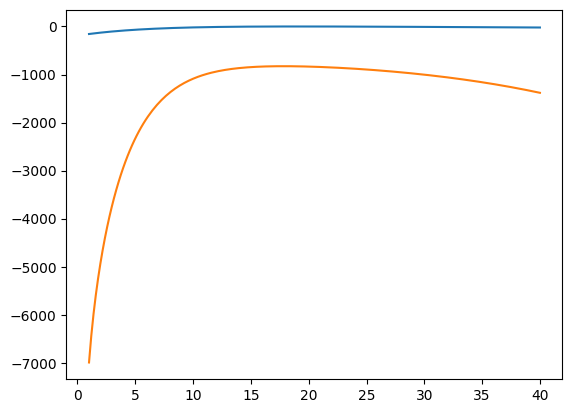

In [63]:
# Least squares
prs = np.zeros_like(ds)
for i, d in enumerate(ds):
    prs[i] = logPr(logLs, mean_X, covinv_ls, d)
plt.plot(ds, prs)
print(ds[np.argmax(prs)])

# Bayesian gaussian
logprs = np.zeros_like(ds)
for i, d in enumerate(ds):
    logprs[i] = logPr_bayes(logLs, mean_X, covinv_X, d)
plt.plot(ds, logprs)
print(ds[np.argmax(logprs)])

### Try on simpler functions

In [72]:
def minimise_d(inverse, logL, mean, cov_inv, x0):
    def func(theta):
        Xstar = inverse(logL, theta)
        abs_fprimes = abs(d * np.ones_like(Xstar))
        return - np.sum(abs_fprimes) - 1/2 * (Xstar - mean).T @ cov_inv @ (Xstar - mean)
    solution = minimize(func, x0)
    return solution

def minimise_model(func, inverse, nk, mean, covinv, x0, dtrue=10):
    Xs = generate_Xs(nk)
    y = func(Xs, dtrue)
    dbest = minimise_d(inverse, y, mean, covinv, x0).x
    return dbest

In [2]:
def linear(X, theta):
    return theta * X

def linear_inverse(y, theta):
    return y/theta

def quad(X, theta):
    return theta * X**2

def quad_inverse(y, theta):
    return (y/theta)**(1/2)

def log(X, theta):
    return theta * np.log(X)

def log_inverse(y, theta):
    return np.exp(y/theta)

In [3]:
def minimise_linear(y, mean, covinv, x0):
    def func(theta):
        Xstar = y / theta
        return 1/2 * (Xstar - mean).T @ covinv @ (Xstar - mean)
    solution = minimize(func, x0)
    return solution

def minimise_linear_bayes(y, mean, covinv, x0):
    def func(theta):
        Xstar = y / theta
        abs_fprimes = abs(theta * np.ones_like(Xstar))
        return np.sum(abs_fprimes) + 1/2 * (Xstar - mean).T @ covinv @ (Xstar - mean)
    solution = minimize(func, x0)
    return solution

In [35]:
nk = 500 * np.ones(100)
mean_X = X_mu(nk)
covinv_X = X_Sigmainv(nk)
covinv_ls = np.eye(len(mean_X))

In [42]:
dtrue = 10
repeats = 20
bs = np.zeros(repeats)
cs = np.zeros(repeats)
ls = np.zeros(repeats)
for i in range(repeats):
    Xs = generate_Xs(nk)
    y = linear(Xs, dtrue)
    bs[i] = minimise_linear_bayes(y, mean_X, covinv_X, 10).x
    cs[i] = minimise_linear(y, mean_X, covinv_X, 10).x
    ls[i] = minimise_linear(y, mean_X, covinv_ls, 10).x

print(f"Bayes: {bs.mean():.3f} +/- {bs.std():.3f}")
print(f"Gaussian: {cs.mean():.3f} +/- {cs.std():.3f}")
print(f"LS: {ls.mean():.3f} +/- {ls.std():.3f}")

Bayes: 9.967 +/- 0.012
Gaussian: 10.006 +/- 0.013
LS: 10.020 +/- 0.139


In [29]:
Xs = generate_Xs(nk)
y = linear(Xs, dtrue)

In [30]:
minimise_linear(y, mean_X, covinv_X, 10).x

array([10.04561819])

In [31]:
minimise_linear_bayes(y, mean_X, covinv_X, 10).x

array([9.6838039])